#Setup

In [55]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

#Data Scrubbing

Load and View Data

In [56]:
data = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/diabetic_data.csv')
data.head() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [57]:
data.shape

(101766, 50)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [59]:
# check the number of object types
data.dtypes.value_counts()

object    37
int64     13
dtype: int64

In this dataset, there are a total of 50 columns. The breakdown is as follows:  
2 of these columns are target variable/labels, and both are text features.  
48 of these columns are features, and 35 are text features and 13 are numeric features.

#Features Engineering


Let's see the correlation of each feature using heatmap

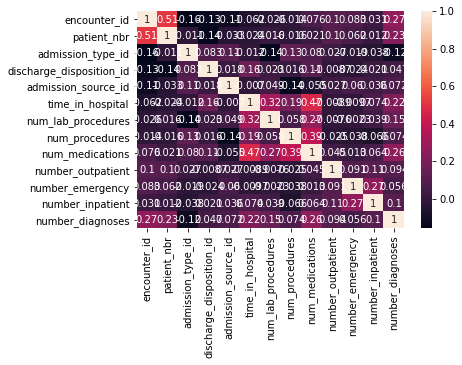

In [60]:
corr = data.corr()
sns.heatmap(corr,annot = True)

This can be seen that there aren't any high correlation greater than 0.9 between each feature.  However, this doesn't mean that all features are needed to be used to create learning model, such as patient_id, physician_id, payer_id, etc. Therefore, FeatureSelector method shall kick in.

Let's drop some columnus that has value as id and missing value greater than 70%

In [61]:
data = data.drop(['encounter_id','patient_nbr','weight','admission_type_id','discharge_disposition_id',
                  'admission_source_id','payer_code','medical_specialty','number_outpatient',
                  'number_emergency','number_inpatient','diag_1','diag_2','diag_3'], axis=1)

data.shape

(101766, 36)

Data Visualization

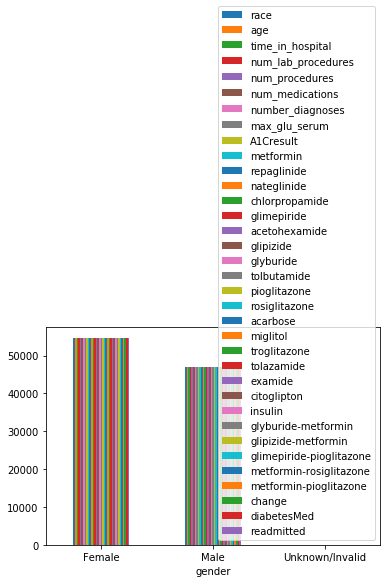

In [62]:
# Group by gender
data.groupby('gender').count().plot.bar(rot=0)

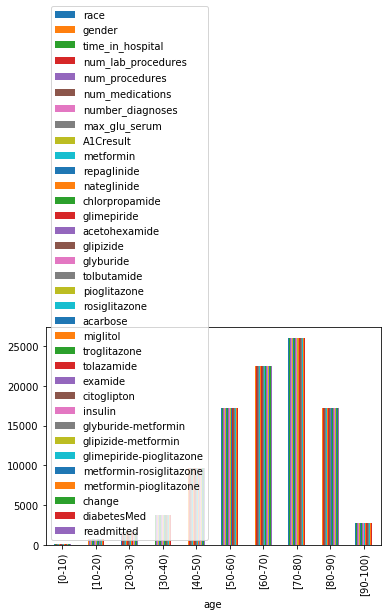

In [63]:
# Group by age
data.groupby('age').count().plot.bar()

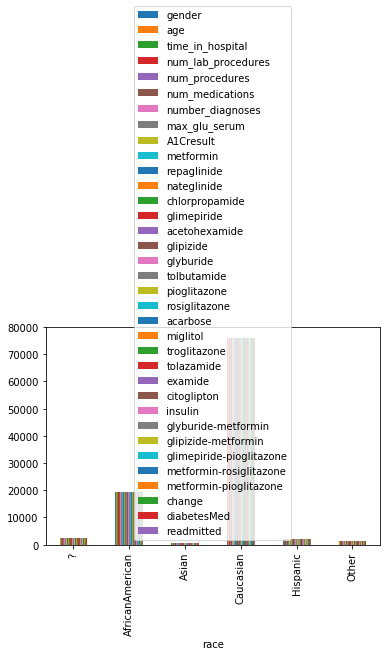

In [64]:
# Group by race
data.groupby('race').count().plot.bar()

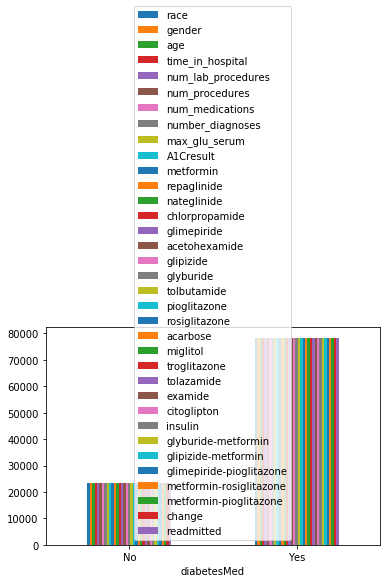

In [65]:
# Group by diabetes medication prescribed
data.groupby('diabetesMed').count().plot.bar(rot=0)

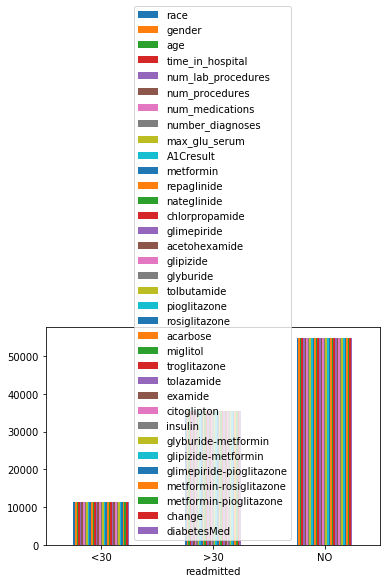

In [66]:
# Group by readmitted
data.groupby('readmitted').count().plot.bar(rot=0)

Choose X features y labels

In [0]:
X_diabetesMed = data.iloc[:,0:34]
X_readmitted = data.iloc[:,0:35]
y_diabetesMed = data.iloc[:,-2] 
y_readmitted = data.iloc[:,-1] 

In [68]:
X_diabetesMed.shape, y_diabetesMed.shape, X_readmitted.shape, y_readmitted.shape

((101766, 34), (101766,), (101766, 35), (101766,))

Convert categorical value to numerical

In [69]:
X_diabetesMed = pd.get_dummies(X_diabetesMed)
X_diabetesMed.shape

(101766, 105)

In [70]:
X_readmitted = pd.get_dummies(X_readmitted)
X_readmitted.shape

(101766, 107)

In [71]:
# convert 'diabetesMed' label to numerical
y_dia = y_diabetesMed.map(lambda x:int(1) if x=='Yes' else int(0))

y_dia.head()

0    0
1    1
2    1
3    1
4    1
Name: diabetesMed, dtype: int64

In [72]:
# convert 'readmitted' label to numerical
y_rea = y_readmitted.map(lambda x:int(0) if x=='No' else int(1) if x=='<30' else int(2))

y_rea.head()

0    2
1    2
2    2
3    2
4    2
Name: readmitted, dtype: int64

Select the best 50 features from both diabetes and readmitted  

In [0]:
from sklearn.feature_selection import SelectKBest, chi2

skb = SelectKBest(chi2, k=50)
X_dia = skb.fit_transform(X_diabetesMed,y_dia) 
X_rea = skb.fit_transform(X_readmitted,y_rea) 

# For vizaulizing the important features
X_dia_fit = skb.fit(X_diabetesMed,y_dia)
X_rea_fit = skb.fit(X_readmitted,y_rea)

For diabetesMed

In [0]:
X_dia_scores = pd.DataFrame(X_dia_fit.scores_)
X_dia_columns = pd.DataFrame(X_diabetesMed.columns)
dia_scores = pd.concat([X_dia_columns,X_dia_scores],axis=1)
dia_scores.columns = ['Features','Score']

See the 50 highest score of importance features 

In [75]:
print(dia_scores.nlargest(50,'Score'))  #print 50 best features

                   Features       Score
3           num_medications  619.710588
0          time_in_hospital  402.990854
1        num_lab_procedures  379.031797
4          number_diagnoses  125.721765
87             insulin_Down   92.357920
88               insulin_No   60.224382
105                     NaN   57.655322
19              age_[50-60)   38.833315
34         metformin_Steady   38.724389
90               insulin_Up   38.245607
2            num_procedures   33.042733
103               change_Ch   20.833336
15              age_[10-20)   20.107193
5                    race_?   19.133618
104               change_No   17.886877
106                     NaN   17.218681
16              age_[20-30)   15.882274
22              age_[80-90)   14.795801
14               age_[0-10)   14.034622
29             A1Cresult_>8   13.767366
25       max_glu_serum_>300   12.728291
31           A1Cresult_Norm   11.333367
33             metformin_No   10.490585
21              age_[70-80)    9.884529


In [0]:
#dia_scores.nlargest(50, 'Score').plot(kind='barh',figsize=(10,10))
#plt.show()

For 'readmitted'

In [0]:
X_rea_scores = pd.DataFrame(X_rea_fit.scores_)
X_rea_columns = pd.DataFrame(X_readmitted.columns)
rea_scores = pd.concat([X_rea_columns,X_rea_scores],axis=1)
rea_scores.columns = ['Features','Score']

See the 50 highest score of importance features 

In [78]:
print(rea_scores.nlargest(50,'Score'))  #print 50 best features

                   Features       Score
3           num_medications  619.710588
0          time_in_hospital  402.990854
1        num_lab_procedures  379.031797
4          number_diagnoses  125.721765
87             insulin_Down   92.357920
88               insulin_No   60.224382
105          diabetesMed_No   57.655322
19              age_[50-60)   38.833315
34         metformin_Steady   38.724389
90               insulin_Up   38.245607
2            num_procedures   33.042733
103               change_Ch   20.833336
15              age_[10-20)   20.107193
5                    race_?   19.133618
104               change_No   17.886877
106         diabetesMed_Yes   17.218681
16              age_[20-30)   15.882274
22              age_[80-90)   14.795801
14               age_[0-10)   14.034622
29             A1Cresult_>8   13.767366
25       max_glu_serum_>300   12.728291
31           A1Cresult_Norm   11.333367
33             metformin_No   10.490585
21              age_[70-80)    9.884529


In [0]:
#rea_scores.nlargest(50, 'Score').plot(kind='barh',figsize=(10,10))
#plt.show()

Split the data for training and testing set in ration 70%-30%

In [0]:
#For diabetesMed
X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_dia,y_dia, test_size=0.3, shuffle = True, random_state=42)

In [0]:
#For readmitted
X_train_rea, X_test_rea, y_train_rea, y_test_rea = train_test_split(X_rea,y_rea, test_size=0.3, shuffle = True, random_state=42)

#Building Pipeline Steps

In [0]:
scaler = preprocessing.Normalizer() #Scale data using normalization 
pca = PCA(n_components=0.95) #Reduce dimension using PCA
rnd_clf = RandomForestClassifier(n_estimators=10) #Number of trees is 50
svm_clf = SVC(gamma='auto', degree=2, kernel='poly') #Non-linear degree=2

#RandomForest Pipline

In [0]:
pipe_rnd = make_pipeline(scaler, pca, rnd_clf)

for 'diabetMed'

In [84]:
# Perform Cross Validation
cross_val_score(pipe_rnd, X_train_dia, y_train_dia, cv=3, scoring='accuracy').mean() 

0.7586472929611959

In [0]:
# Fit the model with training set
t0 = time.time()
pipe_rnd.fit(X_train_dia, y_train_dia)
t1 = time.time()

In [86]:
print("Training took {:.2f}s".format(t1-t0))

Training took 2.78s


In [87]:
# Test the model with testing set
pipe_rnd.score(X_test_dia, y_test_dia)

0.7752374713396659

for 'readmitted'

In [88]:
# Perform Cross Validation
cross_val_score(pipe_rnd, X_train_rea, y_train_rea, cv=3, scoring='accuracy').mean() 

0.8693357310448095

In [0]:
# Fit the model with training set
t0 = time.time()
pipe_rnd.fit(X_train_rea, y_train_rea)
t1 = time.time()

In [90]:
print("Training took {:.2f}s".format(t1-t0))

Training took 3.82s


In [91]:
# Test the model with testing set
pipe_rnd.score(X_test_rea, y_test_rea)

0.8688175565018015

#SVM (nom-linear) Pipeline

In [0]:
pipe_svm = make_pipeline(scaler, pca, svm_clf)

for 'diabetMed'

In [93]:
# Perform Cross Validation
cross_val_score(pipe_svm, X_train_dia, y_train_dia, cv=3, scoring='accuracy').mean()

0.7679684430277289

In [0]:
# Fit the model with training set
t0 = time.time()
pipe_svm.fit(X_train_dia, y_train_dia)
t1 = time.time()

In [95]:
print("Training took {:.2f}s".format(t1-t0))

Training took 47.74s


In [96]:
# Test the model with testing set
pipe_svm.score(X_test_dia, y_test_dia)

0.7748444153291844

for 'readmitted'

In [97]:
# Perform Cross Validation
cross_val_score(pipe_svm, X_train_rea, y_train_rea, cv=3, scoring='accuracy').mean()

0.8886518052231157

In [0]:
# Fit the model with training set
t0 = time.time()
pipe_svm.fit(X_train_rea, y_train_rea)
t1 = time.time()

In [99]:
print("Training took {:.2f}s".format(t1-t0))

Training took 20.50s


In [100]:
# Test the model with testing set
pipe_svm.score(X_test_rea, y_test_rea)

0.8878152636750737

Overall, all accuracies scores are not bad, and we can increase those accuracies by playing around with the n_estimators for RandomForest and degree for SVM non-linear classifier, but the trade off for this approach is time consuming. Therefore, tuning the model using GridSearch CV is recommended.  

#Tuning the RandomForest using GridSearchCV

In [0]:
# Make a new pipeline
pipe_rnd_gs = make_pipeline(scaler, pca, RandomForestClassifier())

In [0]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [50, 100, 200],
                 "randomforestclassifier__max_depth":[10,30,50,100,None],
                 "randomforestclassifier__min_samples_leaf":[5,10,20,40,100],
                 "randomforestclassifier__max_leaf_nodes": [2, 5,10,20]}]

In [0]:
# create a gridsearch of the pipeline, then fit the dataset to find best model
gs = GridSearchCV(pipe_rnd_gs, grid_param, cv=3, verbose=0,n_jobs=-1)

for 'diabetesMed'

In [0]:
# Fit the model with training set
best_model_dia = gs.fit(X_train_dia, y_train_dia)

In [105]:
# Test the model with testing set
best_model_dia.score(X_test_dia, y_test_dia)

0.7812643301670488

for 'readmitted'

In [0]:
# Fit the model with training set
best_model_rea = gs.fit(X_train_rea, y_train_rea)

In [107]:
# Test the model with testing set
best_model_rea.score(X_test_rea, y_test_rea)

0.8878152636750737

#Summary and Conclusion

In this diabete patients dataset, many methods were used at the data cleansing section, especially at the feature engineering phase.  

After many experiments on training models above, the RandomForest model is considered the best model that produced the accuracies around 78% and 89% for 'diabetestMed' 'readmitted, respectively. SVM (non-linear) model also produced similar accuracies but with almost six times different for the learning time. Below is the details bar graphs of the experiment.

![alt text](https://drive.google.com/uc?id=17dDifvTV0gQTWH7qlOKIRvDweBESxJAf)

![alt text](https://drive.google.com/uc?id=1ACIVj_l8Y89mRkh535TOvnF2FIOO4q0n)

GridSearch CV is one of the top techniques to find the best model, but by looking at GridSearch CV learning model with different parameters, still the performance was not improved at all.

Therefore, this can be seen that increasing number of features, n_estimators for RandomForest, degrees for SVM, doesn't improve both models at all; however, RandForest is the best learning model for this dataset.

Dataset Link: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008